# Building a LAS file from scratch

This example shows:

- Creating a pretend/synthetic data curve that we'll call "SYNTH", including some null values
- Creating an empty LASFile object with a default header
- Adding some information to the header
- Adding the synthetic data to the LASFile object
- Writing it to disk as both a LAS version 1.2 and 2.0 file
- Re-loading the file and checking that the null values are interpreted correctly

In [1]:
import lasio

print(lasio.__version__)

import datetime
import numpy
import os
import matplotlib.pyplot as plt
%matplotlib inline

0.5.2


### Step 1

Create some synthetic data, and make some of the values in the middle null values (``numpy.nan`` specifically). Note that of course every curve in a LAS file is recorded against a reference/index, either depth or time, so we create that array too.

In [3]:
depths = numpy.arange(10, 50, 0.5)
synth = numpy.log10(depths) * 10 + numpy.random.random(len(depths))
synth[15:25] = numpy.nan   # Add some null values in the middle

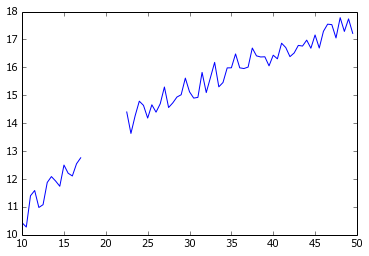

In [4]:
plt.plot(depths, synth)

### Step 2

Create an empty LASFile object and review its header section

In [6]:
l = lasio.LASFile()

In [7]:
l.header

{'~V': {'VERS': HeaderItem(mnemonic='VERS', unit='', value=2.0, descr='CWLS log ASCII Standard -VERSION 2.0'),
 'WRAP': HeaderItem(mnemonic='WRAP', unit='', value='NO', descr='One line per depth step'),
 'DLM': HeaderItem(mnemonic='DLM', unit='', value='SPACE', descr='Column Data Section Delimiter')},
 '~W': {'STRT': HeaderItem(mnemonic='STRT', unit='m', value=nan, descr='START DEPTH'),
 'STOP': HeaderItem(mnemonic='STOP', unit='m', value=nan, descr='STOP DEPTH'),
 'STEP': HeaderItem(mnemonic='STEP', unit='m', value=nan, descr='STEP'),
 'NULL': HeaderItem(mnemonic='NULL', unit='', value=-9999.25, descr='NULL VALUE'),
 'COMP': HeaderItem(mnemonic='COMP', unit='', value='', descr='COMPANY'),
 'WELL': HeaderItem(mnemonic='WELL', unit='', value='', descr='WELL'),
 'FLD': HeaderItem(mnemonic='FLD', unit='', value='', descr='FIELD'),
 'LOC': HeaderItem(mnemonic='LOC', unit='', value='', descr='LOCATION'),
 'PROV': HeaderItem(mnemonic='PROV', unit='', value='', descr='PROVINCE'),
 'CNTY': Hea

Let's add some information to the header: 

- the date
- the operator (in the ~P section)
- a description of the file in the ~O (Other) section.

First, let's change the date.

Note that when changing the value of a ``HeaderItem`` like the ``well["DATE"]`` object above, you must be careful to change the ``value`` attribute rather than the ``HeaderItem`` itself. (This will be made easier in the future.)

In [8]:
l.well["DATE"].value = str(datetime.datetime.today())

Next, let's make a new item in the ~Parameters section for the operator. To do this we need to make a new ``HeaderItem``:

In [10]:
# HeaderItem = namedlist("HeaderItem", ["mnemonic", "unit", "value", "descr"])
l.params["ENGI"] = lasio.HeaderItem("ENGI", "", "kinverarity@hotmail.com", "Creator of this file...")

And finally, add some free text to the ~Other section:

In [11]:
l.other = "Example of how to create a LAS file from scratch using las_reader"

## Step 3

Add the curves to the LAS file using the ``add_curve`` method:

In [12]:
l.add_curve("DEPT", depths, unit="m")
l.add_curve("SYNTH", synth, descr="Synthetic data")

## Step 4

Now let's write out two files: one according to the LAS file specification version 1.2, and one according to 2.0. Note that by default an empty ``LASFile`` object is version 2.0.

In [16]:
fn = "scratch_example_v2.las"
if os.path.exists(fn):  # Remove file if it already exists
    os.remove(fn)
with open(fn, mode="w") as f: # Write LAS file to disk
    l.write(f)
with open(fn, mode="r") as f: # Show the result... 
    print(f.read())

~Version ---------------------------------------------------
VERS      .                                     1.2 : CWLS LOG ASCII STANDARD - VERSION 1.2
WRAP      .                                      NO : One line per depth step
DLM       .                                   SPACE : Column Data Section Delimiter
~Well ------------------------------------------------------
STRT      .m                                   10.0 : START DEPTH
STOP      .m                                   49.5 : STOP DEPTH
STEP      .m                                    0.5 : STEP
NULL      .                                -9999.25 : NULL VALUE
COMP      .                                 COMPANY : 
WELL      .                                    WELL : 
FLD       .                                   FIELD : 
LOC       .                                LOCATION : 
PROV      .                                PROVINCE : 
CNTY      .                                  COUNTY : 
STAT      .                            

In [17]:
fn2 = "scratch_example_v1.2.las"
if os.path.exists(fn2):  # Remove file if it already exists
    os.remove(fn2)
with open(fn2, mode="w") as f: # Write LAS file to disk
    l.write(f, version=1.2)
with open(fn2, mode="r") as f: # Show the result... 
    print(f.read())

~Version ---------------------------------------------------
VERS      .                                     1.2 : CWLS LOG ASCII STANDARD - VERSION 1.2
WRAP      .                                      NO : One line per depth step
DLM       .                                   SPACE : Column Data Section Delimiter
~Well ------------------------------------------------------
STRT      .m                                   10.0 : START DEPTH
STOP      .m                                   49.5 : STOP DEPTH
STEP      .m                                    0.5 : STEP
NULL      .                                -9999.25 : NULL VALUE
COMP      .                                 COMPANY : 
WELL      .                                    WELL : 
FLD       .                                   FIELD : 
LOC       .                                LOCATION : 
PROV      .                                PROVINCE : 
CNTY      .                                  COUNTY : 
STAT      .                            

## Step 5

And finally let's read in the resulting v1.2 file and see if the data is there correctly...

In [19]:
l_v12 = lasio.read(fn)
print("Reading in %s" % fn)
print(l_v12.keys())

Reading in scratch_example_v2.las
['DEPT', 'SYNTH']


HeaderItem(mnemonic='DATE', unit='', value='2015-08-05 15:58:26.698038', descr='DATE')


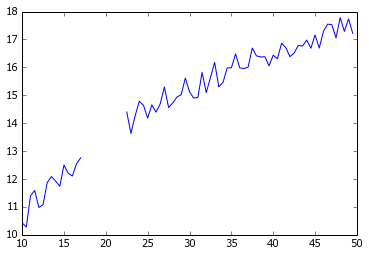

In [20]:
plt.plot(l_v12["DEPT"], l_v12["SYNTH"])
print(l_v12.well["DATE"])

In [21]:
os.remove(fn)
os.remove(fn2)